Import all necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch


Load and inspect data

In [ ]:
data = pd.read_csv('world-data-2023.csv')
data.head()

,Country,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,Co2-Emissions,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,"8,672",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,"4,536",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,"150,006",...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626
3,Andorra,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,469,...,36.40%,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801
4,Angola,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,"34,693",...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887


Extract relevant features, and split it into numerics/country (for labelling)

In [16]:
relevant_features = ['Country', 'Birth Rate', 'Fertility Rate', 'Gross primary education enrollment (%)', 
                     'Gross tertiary education enrollment (%)', 'Infant mortality', 'Life expectancy',
                     'Maternal mortality ratio', 'Out of pocket health expenditure', 'Physicians per thousand']

filtered_data = data[relevant_features]
filtered_data = filtered_data.copy()
countries = filtered_data['Country']
numeric_data = filtered_data.drop(columns='Country')

numeric_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Birth Rate                               189 non-null    float64
 1   Fertility Rate                           188 non-null    float64
 2   Gross primary education enrollment (%)   188 non-null    object 
 3   Gross tertiary education enrollment (%)  183 non-null    object 
 4   Infant mortality                         189 non-null    float64
 5   Life expectancy                          187 non-null    float64
 6   Maternal mortality ratio                 181 non-null    float64
 7   Out of pocket health expenditure         188 non-null    object 
 8   Physicians per thousand                  188 non-null    float64
dtypes: float64(6), object(3)
memory usage: 13.8+ KB


In [17]:
filtered_data.head()

,Country,Birth Rate,Fertility Rate,Gross primary education enrollment (%),Gross tertiary education enrollment (%),Infant mortality,Life expectancy,Maternal mortality ratio,Out of pocket health expenditure,Physicians per thousand
0,Afghanistan,32.49,4.47,104.00%,9.70%,47.9,64.5,638.0,78.40%,0.28
1,Albania,11.78,1.62,107.00%,55.00%,7.8,78.5,15.0,56.90%,1.20
2,Algeria,24.28,3.02,109.90%,51.40%,20.1,76.7,112.0,28.10%,1.72
3,Andorra,7.20,1.27,106.40%,NaN,2.7,NaN,NaN,36.40%,3.33
4,Angola,40.73,5.52,113.50%,9.30%,51.6,60.8,241.0,33.40%,0.21


Convert all to numerics and drop NA's

In [26]:
for col in numeric_data:
    numeric_data[col] = (
        numeric_data[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '', regex=False)
    )
    numeric_data[col] = pd.to_numeric(numeric_data[col], errors='coerce')

In [27]:
numeric_data = numeric_data.fillna(numeric_data.mean())

In [33]:
print(numeric_data.dtypes)

Birth Rate                                 float64
Fertility Rate                             float64
Gross primary education enrollment (%)     float64
Gross tertiary education enrollment (%)    float64
Infant mortality                           float64
Life expectancy                            float64
Maternal mortality ratio                   float64
Out of pocket health expenditure           float64
Physicians per thousand                    float64
dtype: object


In [ ]:
#Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

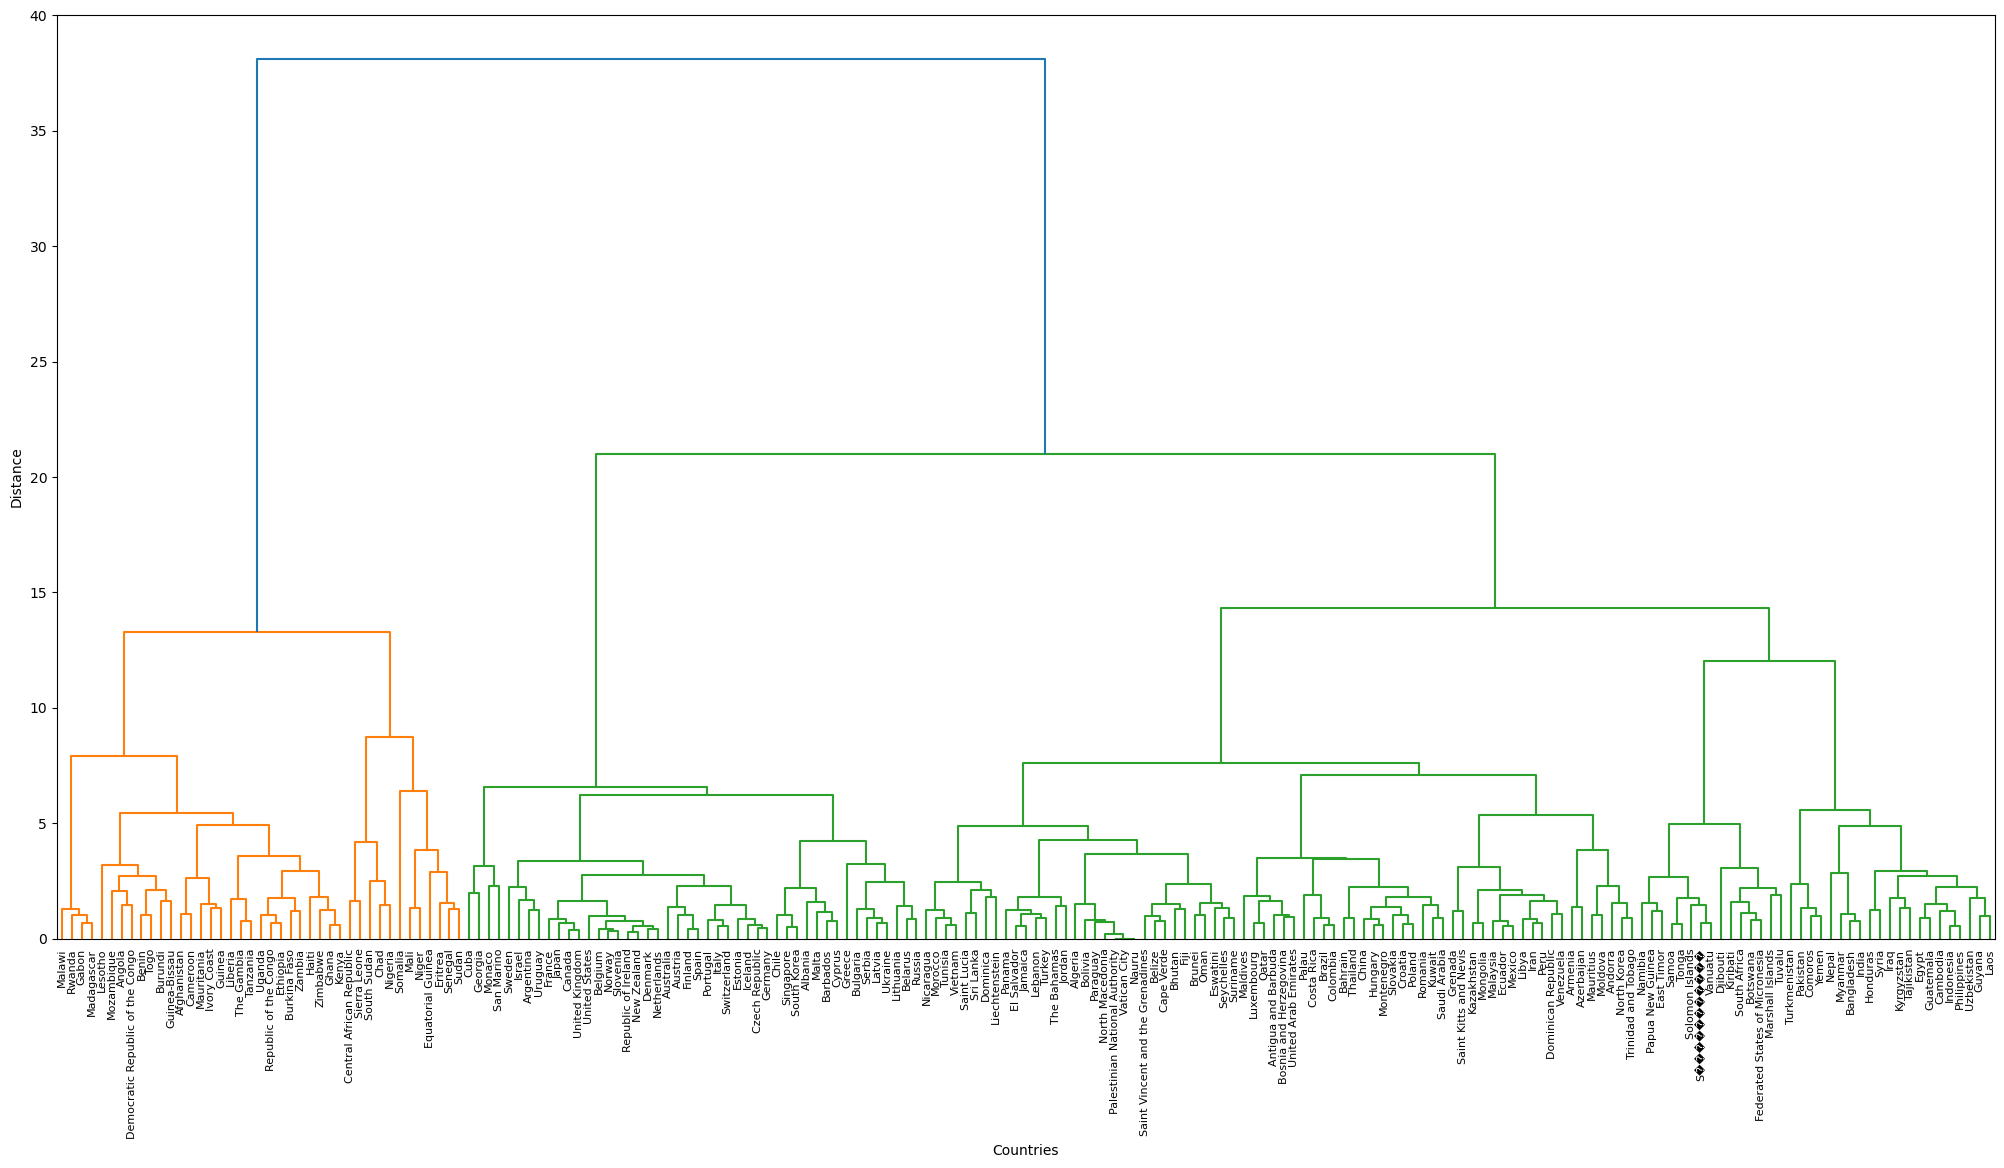

In [ ]:
#Plot Dendrogram for inspection
plt.figure(figsize=(25, 12))
dendrogram = sch.dendrogram(
    sch.linkage(scaled_data, method='ward'),
    labels=countries.values,
    leaf_rotation=90,
    leaf_font_size=8
)
plt.xlabel('Countries')
plt.ylabel('Distance')
plt.show()

Dendrogram is quite dense, hard to interpret an appropriate number of clusters. Will compute silhouette score to assist. 

In [ ]:
#Compute silhouette score
for k in range(2, 7):
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = hc.fit_predict(scaled_data)
    
    score = silhouette_score(scaled_data, labels)
    print(f"Number of clusters: {k}, Silhouette score: {score:.3f}")

Number of clusters: 2, Silhouette score: 0.436
Number of clusters: 3, Silhouette score: 0.245
Number of clusters: 4, Silhouette score: 0.188
Number of clusters: 5, Silhouette score: 0.193
Number of clusters: 6, Silhouette score: 0.213


K=2 is highest by far, will be used for the model

In [35]:
hc = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels = hc.fit_predict(scaled_data)

results = pd.DataFrame({
    'Country': countries,
    'Cluster': labels
})
print(results.head())


       Country  Cluster
0  Afghanistan        1
1      Albania        0
2      Algeria        0
3      Andorra        0
4       Angola        1


In [ ]:
# View cluster statistics
clustered_data = numeric_data.copy()
clustered_data['Country'] = countries
clustered_data['Cluster'] = labels

print(clustered_data.groupby('Cluster').mean(numeric_only=True))

         Birth Rate  Fertility Rate  Gross primary education enrollment (%)  \
Cluster                                                                       
0         16.273116        2.177318                              102.918127   
1         35.020976        4.654390                              100.787805   

         Gross tertiary education enrollment (%)  Infant mortality  \
Cluster                                                              
0                                      45.898684         13.664265   
1                                       8.157644         50.136585   

         Life expectancy  Maternal mortality ratio  \
Cluster                                              
0              75.156737                 64.334362   
1              61.473171                521.195122   

         Out of pocket health expenditure  Physicians per thousand  
Cluster                                                             
0                               30.756645      